In [1]:
import sys, os
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import linregress

cmap = cm.get_cmap('Spectral')
rgba1 = cmap(0)
rgba2 = cmap(0.25)
rgba3 = cmap(0.5)
rgba4 = cmap(0.75)
rgba5 = cmap(0.9)
rgba6 = cmap(0.99) 

home_dir           = '/Users/liz/Documents/GitHub/paper-epi-backprojection/data/analysis-visualization'
data_dir           = '/Users/liz/Documents/GitHub/paper-epi-backprojection/data/SC2_BP_Data'
inf_plot_home      = os.path.join(home_dir, 'inference-plotting')
inf_plot_bp_home   = os.path.join(home_dir, 'inference-plotting-bp')

# helper date function
def get_day(day):
    ref_date = datetime.date(2020, 1, 1)
    target = ref_date + datetime.timedelta(day)
    return(target.strftime("%m-%d-%y"))

# helper sizing function
def cm2inch(x): 
    return float(x)/2.54

# global values paper size
SINGLE_COLUMN = cm2inch(8.8)
DOUBLE_COLUMN = cm2inch(18.0)

# size and font parameters
FONTFAMILY    = 'Arial'
SIZESUBLABEL  = 8
SIZE_LABEL     = 6
SIZE_TICK      = 6
SMALLSIZEDOT  = 6.
SIZELINE      = 0.6
AXES_FONTSIZE = 6
AXWIDTH       = 0.4

# helper function legend
def extract_numeric(arr):
    numeric_values = []
    for item in arr:
        match = re.match(r'(\d+)', str(item))
        if match:
            numeric_values.append(int(match.group(1)))
    return np.array(numeric_values)

def load_npz_covar(path):
    
    #path = targeted country
    
    npz_files = [f for f in os.listdir(path) if f != ".DS_Store"]
    
    time_l = []
    count_l = []

    for file in sorted(npz_files):
        filepath = os.path.join(path, file)
        data = np.load(filepath, allow_pickle=True)
        times = data['times']
        counts = data['counts']
        refs = data['ref_sites']
        time_l.append(times)
        count_l.append(counts)

    x = np.concatenate(time_l)
    y = np.concatenate(count_l)
    z = refs
    #print(z)
    #print(np.min(x))
    #print(np.max(x))
    #print(np.min(x) , '-' , np.max(x))
    #print(str(abs(np.min(x)-np.max(x))))
    
    return x, y, z

def plot_covar(ax, x, y, z, plot_label, scalar_map):
    # set font param
    mpl.rc('font', family='Arial')
    
    # load in reference site data
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    # labeling nucleotides in npz file
    new_labels = []
    NUC = ['-', 'A', 'C', 'G', 'T']
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)        
    
    # reference genome labeling and filtering
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')
    
    # finding indices of reference sites (based on needle-haystack approach)
    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]
    
    # converting times into dates
    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    # plot trajectories
    num_lines = y.shape[1]
    
    for i in range(num_lines):
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            color = scalar_map.to_rgba(i)
            ax.plot(x_dates, y_line, linewidth=0.6, color=color)
    
    ax.set_ylabel('Allele frequency', font='Arial', size=6, labelpad=10)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', labelsize=6, rotation=35, width=0.6)
    ax.tick_params(axis='y', labelsize=6, width=0.6)

    
    #ax.tick_params(axis='x', rotation=45, labelsize=6, width=0.6)

    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    plt.setp(ax.get_xticklabels(), ha='center')
    
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
    
    ax.set_title(plot_label, x=0.22, y=0.97, fontsize=8)

def plot_spike_covar(ax, x, y, z, plot_label):
    # set font param
    mpl.rc('font', family='Arial')
    
    # load in reference site data
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    # labeling nucleotides in npz file
    new_labels = []
    NUC = ['-', 'A', 'C', 'G', 'T']
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)        
    
    # reference genome labeling and filtering
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')
    
    # finding indices of reference sites (based on needle-haystack approach)
    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]
    
    # converting times into dates
    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    # plot trajectories
    
    num_lines = y.shape[1]
    for i in range(num_lines):
        site_label = new_labels[i]
        # handles reference genome insertion characters (22203a-y)
        if isinstance(site_label, str):
            site_value = int(re.sub(r'\D', '', site_label))
        else:
            site_value = int(site_label)
        # binary based on spike protein sites
        col = 'k' if (21562 <= site_value < 25384) else 'green'
        #col = 'xkcd:viridian' if (21562 <= site_value < 25384) else 'xkcd:grayish purple'
        
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            ax.plot(x_dates, y_line, linewidth=0.6, color=col)
    
    ax.set_ylabel('Allele frequency', font='Arial', size=6, labelpad=10)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', rotation=45, labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    
    ax.set_title(plot_label, x=1.15, y=0.45, fontsize=6)

def plot_covar_exp(ax, x, y, z, plot_label, scalar_map):
    # set font param
    mpl.rc('font', family='Arial')
    
    # load in reference site data
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    # labeling nucleotides in npz file
    new_labels = []
    NUC = ['-', 'A', 'C', 'G', 'T']
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)        
    
    # reference genome labeling and filtering
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')
    
    # finding indices of reference sites (based on needle-haystack approach)
    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]
    
    # converting times into dates
    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    # plot trajectories
    num_lines = y.shape[1]
    
    ''' for loop for spectrum color bar: comment out if needed '''
    '''
    for i in range(num_lines):
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            color = scalar_map.to_rgba(i)
            ax.plot(x_dates, y_line, linewidth=1.4, color=color)
    '''
    
    ''' for loop for binary spike legend: comment out if needed '''  
    
    for i in range(num_lines):
        site_label = new_labels[i]
        # handles reference genome insertion characters (22203a-y)
        if isinstance(site_label, str):
            site_value = int(re.sub(r'\D', '', site_label))
        else:
            site_value = int(site_label)
        
        ### comment one or other out
        # binary based on spike protein sites
        col = 'xkcd:viridian' if (21562 <= site_value < 25384) else 'xkcd:grayish purple'
        #col = 'xkcd:cobalt blue' if (21562 <= site_value < 25384) else 'xkcd:orchid'
        # binary based on structural sites
        #col = 'xkcd:cobalt blue' if (21562 <= site_value) else 'xkcd:orchid'
        #col = 'xkcd:viridian' if (21562 <= site_value) else 'xkcd:grayish purple'
        
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            ax.plot(x_dates, y_line, linewidth=0.6, color=col, alpha=0.6)
    
    ax.set_ylabel('Allele frequency', font='Arial', size=6, labelpad=10)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', rotation=35, labelsize=6, width=0.6)
    #ax.tick_params(axis='x', rotation=45, labelsize=6, width=0.6)
    ax.tick_params(axis='y', labelsize=6, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
        
    plt.setp(ax.get_xticklabels(), ha='center')
    
    ax.set_title(plot_label, x=0.22, y=0.97, fontsize=8)
    #ax.set_title(plot_label, x=0.4, y=0.32, fontsize=8)
    
def covar_spike_figure(index, home_dir):
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    # create figure
    
    #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
        # this shares xdates, and doesn't do it quite right
    
    #fig = plt.figure(figsize=(16, 10))
    #fig, ax = plt.subplots(figsize=(SINGLE_COLUMN, SINGLE_COLUMN/2))
    fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN/1.25))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.5)
    
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    ax1.set_xlabel('a', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax2.set_xlabel('b', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')
    
    plot_spike_covar(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections')
    plot_spike_covar(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections')
    
    # legend, custom
    spike_patch = mpatches.Patch(color='k', label='Spike Mutants')
    other_patch = mpatches.Patch(color='green', label='Other Mutants')
    
    handles = [spike_patch, other_patch]
    fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.22, 0.5), ncol=1, frameon=False,fontsize=6)  # Legend on the right side
    fig.supxlabel('Date', fontsize=6, y=-0.12, x=0.52)
    
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.9, hspace=0.9)
    #plt.show()
    
    save_path = f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/1_supplementary_covar_{index}.pdf'
    print(f"saving plot to: {save_path}")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

def covar_figure(index, home_dir):
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    # create figure
    
    #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
        # this shares xdates, and doesn't do it quite right
    
    fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.8)
    
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    ax1.set_xlabel('a', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax2.set_xlabel('b', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')

    # create shared colormap
    num_lines = un_sel_y.shape[1]
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)

    # plot trajectories
    plot_covar(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', scalar_map)
    plot_covar(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', scalar_map)
    
    # new map and parameters for custom colorbar legend
    ref_sites = extract_numeric(un_ref_z)
    percentiles = np.percentile(ref_sites, [0, 25, 50, 75, 100])
    norm_cbar = Normalize(vmin=min(ref_sites), vmax=max(ref_sites))
    scalar_map = cm.ScalarMappable(norm=norm_cbar, cmap=cmap)
    cax = fig.add_axes([0.94, 0.38, 0.04, 0.25])
    cbar = fig.colorbar(scalar_map, cax=cax)
    
    cbar.set_label('Mutation sites', font='Arial', size=6, labelpad=-40)
    cbar.set_ticks(percentiles)
    cbar.set_ticklabels([f'{int(p)}' for p in percentiles])
    cbar.outline.set_linewidth(0.6)
    #cbar.ax.set_xlabel(loc='left')

    for label in cbar.ax.get_yticklabels():
        label.set_fontname('Arial')
        label.set_fontsize(6)

    fig.supxlabel('Date', fontsize=6, y=-0.10, x=0.51)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.8)
    
    #plt.show()
    
    save_path = f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/1_supplementary_covar_{index}_colorbar_small.pdf'
    print(f"saving plot to: {save_path}")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

def covar_figure_exp(index, home_dir):
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    # create figure
    
    #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
        # this shares xdates, and doesn't do it quite right
    
    #fig = plt.figure(figsize=(16, 10))
    fig = plt.figure(figsize=(SINGLE_COLUMN, (SINGLE_COLUMN/1.25)))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.8)
    
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    ax1.set_xlabel('a', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax2.set_xlabel('b', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')
    
    '''creates spectrum colormap, comment out if needed'''
    '''
    # create shared colormap
    num_lines = un_sel_y.shape[1]
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)

    # plot trajectories
    plot_covar_exp(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', scalar_map)
    plot_covar_exp(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', scalar_map)
    
    # new map and parameters for custom colorbar legend
    ref_sites = extract_numeric(un_ref_z)
    
    percentiles = np.percentile(ref_sites, [0, 25, 50, 75, 100])
    norm_cbar = Normalize(vmin=min(ref_sites), vmax=max(ref_sites))
    scalar_map = cm.ScalarMappable(norm=norm_cbar, cmap=cmap)
    cax = fig.add_axes([1, 0.35, 0.03, 0.3])
    cbar = fig.colorbar(scalar_map, cax=cax)
    cbar.set_label('Mutation sites', font='Arial', size=20, labelpad=40)
    
    ### spike markers comment out if needed
    spike = [21563,25384]
    cbar.set_ticks(spike)
    cbar.set_ticklabels(['spike start codon ' + str(spike[0]), 'spike end codon ' + str(spike[1])])
    
    ### percentile markers comment out if needed
    #cbar.set_ticks(percentiles)
    #cbar.set_ticklabels([f'{int(p)}' for p in percentiles])
    
    for label in cbar.ax.get_yticklabels():
        label.set_fontname('Arial')
        label.set_fontsize(16)
    '''
    
    ''' binary legend, comment out if needed'''     
    
    # plot trajectories
    plot_covar_exp(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', None)
    plot_covar_exp(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', None)
    
    # legend, custom
    ''' spike custom, comment out if needed '''
    
    spike_patch = mpatches.Patch(color='xkcd:viridian', label='Spike Mutants', alpha = 0.6)
    other_patch = mpatches.Patch(color='xkcd:grayish purple', label='Other Mutants', alpha = 0.6)
    handles = [spike_patch, other_patch]
    
    
    '''
    spike_patch = mpatches.Patch(color='xkcd:cobalt blue', label='Spike Mutants', alpha = 0.6)
    other_patch = mpatches.Patch(color='xkcd:orchid', label='Other Mutants', alpha = 0.6)
    handles = [spike_patch, other_patch]
    '''
    
    '''
    struct_patch = mpatches.Patch(color='xkcd:cobalt blue', alpha=0.6, label='Structural Mutants')
    nonstruct_patch = mpatches.Patch(color='xkcd:orchid', alpha=0.6, label='Non-structural Mutants')
    handles = [struct_patch, nonstruct_patch]
    '''
    
    '''
    struct_patch = mpatches.Patch(color='xkcd:viridian', alpha=0.6, label='Structural Mutants')
    nonstruct_patch = mpatches.Patch(color='xkcd:grayish purple', alpha=0.6, label='Non-structural Mutants')
    handles = [struct_patch, nonstruct_patch]
    '''
    fig.legend(handles=handles, loc='center right', bbox_to_anchor=(0.92, 0.75), ncol=1, fontsize=6, frameon=False)  # Legend on the right side
    
    

    fig.supxlabel('Date', fontsize=6, y=-0.12, x=0.51)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.8)
    
    #plt.show()
    
    save_path = f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/1_covar_{index}_spike_hk_struct.pdf'
    print(f"saving plot to: {save_path}")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

def plot_inf(ax, x, y, index):
    
    #plt.subplots(figsize=(12,12))
    #plt.subplots(figsize=(8,8))
    plt.subplots(figsize=(SINGLE_COLUMN, SINGLE_COLUMN))
    #fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN))
    plt.plot(x, y, 'o', color=rgba1, markersize=0.4)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color=rgba6,linewidth=0.8)

    ax = plt.gca()
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color=rgba5,linestyle='dashed',linewidth=0.6)
    ax.set_xlim(xmin=-.03, xmax=.05)
    ax.set_ylim(ymin=-.03, ymax=.05)
    
    x_title = 'Inferred selection coefficient, ' + r'$\hat{s}$' + '\nSample collection times'
    y_title = 'Inferred selection coefficient, ' + r'$\hat{s}$' + '\nInferred infection times'
    #x_title = r"$\pi$"
    ax.set_xlabel(xlabel=x_title, font='Arial', size=6, labelpad=10, math_fontfamily='stixsans')
    ax.set_ylabel(ylabel=y_title, font='Arial', size=6, labelpad=10, math_fontfamily='stixsans')
    #plt.title('Selection coefficient comparison', font='Arial', size=20, pad=20)
    plt.subplots_adjust(bottom=0.15)

    ax.set_aspect('equal', adjustable='box')
    
    ax.tick_params(axis='x', labelsize=6, width=0.6)
    ax.tick_params(axis='y', labelsize=6, width=0.6)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')
    
    for line in ['top', 'right']:
        ax.spines[line].set_linewidth(0.5)
        #ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    
    #plt.rcParams['axes.linewidth'] = 0.6
    
    #plt.ion()
    #plt.show()
    
    #plt.savefig('')
    print(linregress(x, y))

def inf_figure(index, inf_plot_home, inf_plot_bp_home, plot_function):
    
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    fig3 = plot_function(un_sel, bp_sel, index)
    plt.savefig(f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/test_small_inf_{index}.pdf', dpi=300, bbox_inches='tight')
    return fig3

In [ ]:
inf_figure(4, inf_plot_home, inf_plot_bp_home, plot_inf)

In [ ]:
inf_figure(13, inf_plot_home, inf_plot_bp_home, plot_inf)

In [ ]:
fig = covar_spike_figure(4, home_dir)

In [ ]:
fig = covar_figure(13, home_dir)

In [ ]:
fig = covar_figure_exp(13, home_dir)

LinregressResult(slope=0.9404216615373164, intercept=0.00015832998893173362, rvalue=0.9593123716055136, pvalue=0.0, stderr=0.00555465701394936, intercept_stderr=2.1766032616172233e-05)


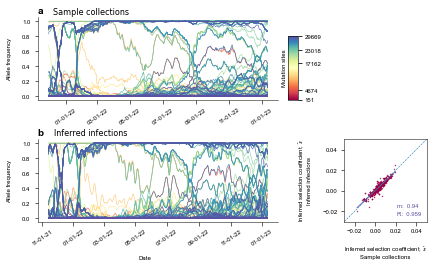

In [2]:
from matplotlib.lines import Line2D
def plot_inf_supp(ax, x, y, index):
    mpl.rc('font', family='Arial')

    ax.plot(x, y, 'o', color=rgba1, markersize=0.4)

    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color=rgba6, linewidth=0.8)

    #ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 2))(np.unique(x)), color='xkcd:vermillion', linewidth=0.8)

    
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color=rgba5, linestyle='dashed', linewidth=0.6)

    ax.set_xlim(xmin=-0.03, xmax=0.05)
    ax.set_ylim(ymin=-0.03, ymax=0.05)

    x_title = 'Inferred selection coefficient, ' + r'$\hat{s}$' + '\nSample collections'
    y_title = 'Inferred selection coefficient, ' + r'$\hat{s}$' + '\nInferred infections'
    ax.set_xlabel(xlabel=x_title, font='Arial', size=6, labelpad=10, math_fontfamily='stixsans')
    ax.set_ylabel(ylabel=y_title, font='Arial', size=6, labelpad=10, math_fontfamily='stixsans')

    ax.set_aspect('equal', adjustable='box')
    ax.tick_params(axis='x', labelsize=6, width=0.6)
    ax.tick_params(axis='y', labelsize=6, width=0.6)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')
        
    for line in ['top', 'right']:
        ax.spines[line].set_linewidth(0.5)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
        
    lr = linregress(x, y)
        
    custom_shapes = [Line2D([0], [0], marker='o', color='w', alpha=0),
                     Line2D([0], [0], marker='o', color='w', alpha=0)]    
    custom_labels = ['m:  ' + str(round(lr.slope, 3)), 'R:  ' + str(round(lr.rvalue, 3))]
    
    ax.legend(custom_shapes, custom_labels, loc='lower right', fontsize=6, labelcolor=rgba6, frameon=False)

    #for t in leg.get_texts():
    #    t.set_ha('left')
    
    
    print(linregress(x, y))

def supp_figure(index, home_dir):
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    # from inf_figure function
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])

    fig = plt.figure(figsize=(DOUBLE_COLUMN, DOUBLE_COLUMN/2))
    #gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.5)
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.48)
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot

    
    
    ax1.set_xlabel('a', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax2.set_xlabel('b', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')

    num_lines = un_sel_y.shape[1]
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)

    plot_covar(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', scalar_map)
    plot_covar(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', scalar_map)
    
    plot_inf_supp(ax3, un_sel, bp_sel, index)

    # shared colorbar (next to ax1)
    ref_sites = extract_numeric(un_ref_z)
    percentiles = np.percentile(ref_sites, [0, 25, 50, 75, 100])
    norm_cbar = Normalize(vmin=min(ref_sites), vmax=max(ref_sites))
    scalar_map = cm.ScalarMappable(norm=norm_cbar, cmap=cmap)
    cax = fig.add_axes([0.59, 0.578, 0.02, 0.25])
    #cax = fig.add_axes([0.94, 0.4, 0.02, 0.25])
    cbar = fig.colorbar(scalar_map, cax=cax)
    
    cbar.set_label('Mutation sites', font='Arial', size=6, labelpad=-40)
    cbar.set_ticks(percentiles)
    cbar.set_ticklabels([f'{int(p)}' for p in percentiles])
    cbar.outline.set_linewidth(0.6)

    for label in cbar.ax.get_yticklabels():
        label.set_fontname('Arial')
        label.set_fontsize(6)

    #fig.supxlabel('Date', fontsize=6, y=-0.10, x=0.51)
    fig.supxlabel('Date', fontsize=6, y=-0.05, x=0.31)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.8)
    
    #save_path = f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/supplementary_case_{index}_color_legendtest.pdf'
    #print(f"saving plot to: {save_path}")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

fig = supp_figure(15, home_dir)


LinregressResult(slope=0.9404216615373164, intercept=0.00015832998893173362, rvalue=0.9593123716055136, pvalue=0.0, stderr=0.00555465701394936, intercept_stderr=2.1766032616172233e-05)


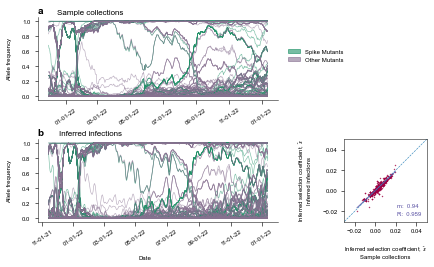

In [3]:
def supp_figure_spike(index, home_dir):
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    # from inf_figure function
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])

    fig = plt.figure(figsize=(DOUBLE_COLUMN, DOUBLE_COLUMN/2))
    #gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.5)
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.48)
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot

    
    
    ax1.set_xlabel('a', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax2.set_xlabel('b', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')

    plot_covar_exp(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', None)
    plot_covar_exp(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', None)
    
    plot_inf_supp(ax3, un_sel, bp_sel, index)
    
    # legend, custom
    
    spike_patch = mpatches.Patch(color='xkcd:viridian', label='Spike Mutants', alpha = 0.6)
    other_patch = mpatches.Patch(color='xkcd:grayish purple', label='Other Mutants', alpha = 0.6)
    handles = [spike_patch, other_patch]

    #fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.22, 0.5), ncol=1, frameon=False,fontsize=6)  # Legend on the right side
    
    fig.legend(handles=handles, loc='center right', bbox_to_anchor=(0.71, 0.75), ncol=1, fontsize=6, frameon=False)  # Legend on the right side
    
    
    
    #fig.supxlabel('Date', fontsize=6, y=-0.12, x=0.52)
    
    #plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.9, hspace=0.9)



    #fig.supxlabel('Date', fontsize=6, y=-0.10, x=0.51)
    fig.supxlabel('Date', fontsize=6, y=-0.05, x=0.31)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.8)
    
    #save_path = f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/supplementary_case_{index}_spike.pdf'
    #print(f"saving plot to: {save_path}")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

fig = supp_figure_spike(15, home_dir)

LinregressResult(slope=0.9404216615373164, intercept=0.00015832998893173362, rvalue=0.9593123716055136, pvalue=0.0, stderr=0.00555465701394936, intercept_stderr=2.1766032616172233e-05)
saving plot to: /Users/liz/Documents/GitHub/paper-epi-backprojection/figures/supplementary_case_15_struct.pdf


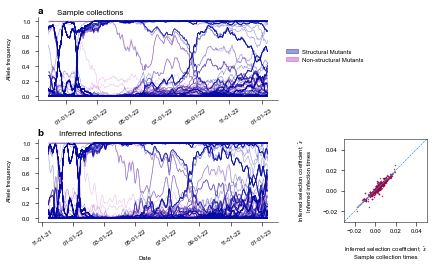

In [153]:
def plot_covar_exp(ax, x, y, z, plot_label, scalar_map):
    # set font param
    mpl.rc('font', family='Arial')
    
    # load in reference site data
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    # labeling nucleotides in npz file
    new_labels = []
    NUC = ['-', 'A', 'C', 'G', 'T']
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)        
    
    # reference genome labeling and filtering
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')
    
    # finding indices of reference sites (based on needle-haystack approach)
    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]
    
    # converting times into dates
    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    # plot trajectories
    num_lines = y.shape[1]
    
    ''' for loop for spectrum color bar: comment out if needed '''
    '''
    for i in range(num_lines):
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            color = scalar_map.to_rgba(i)
            ax.plot(x_dates, y_line, linewidth=1.4, color=color)
    '''
    
    ''' for loop for binary spike legend: comment out if needed '''  
    
    for i in range(num_lines):
        site_label = new_labels[i]
        # handles reference genome insertion characters (22203a-y)
        if isinstance(site_label, str):
            site_value = int(re.sub(r'\D', '', site_label))
        else:
            site_value = int(site_label)
        
        ### comment one or other out
        # binary based on spike protein sites
        #col = 'xkcd:viridian' if (21562 <= site_value < 25384) else 'xkcd:grayish purple'
        #col = 'xkcd:cobalt blue' if (21562 <= site_value < 25384) else 'xkcd:orchid'
        # binary based on structural sites
        col = 'xkcd:cobalt blue' if (21562 <= site_value) else 'xkcd:orchid'
        #col = 'xkcd:viridian' if (21562 <= site_value) else 'xkcd:grayish purple'
        
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            ax.plot(x_dates, y_line, linewidth=0.6, color=col, alpha=0.4)
    
    ax.set_ylabel('Allele frequency', font='Arial', size=6, labelpad=10)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', rotation=35, labelsize=6, width=0.6)
    #ax.tick_params(axis='x', rotation=45, labelsize=6, width=0.6)
    ax.tick_params(axis='y', labelsize=6, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
        
    plt.setp(ax.get_xticklabels(), ha='center')
    
    ax.set_title(plot_label, x=0.22, y=0.97, fontsize=8)
    #ax.set_title(plot_label, x=0.4, y=0.32, fontsize=8)
    
def supp_figure_struct(index, home_dir):
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    # from inf_figure function
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])

    fig = plt.figure(figsize=(DOUBLE_COLUMN, DOUBLE_COLUMN/2))
    #gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.5)
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.48)
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot

    
    
    ax1.set_xlabel('a', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax2.set_xlabel('b', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')

    plot_covar_exp(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', None)
    plot_covar_exp(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', None)
    
    plot_inf_supp(ax3, un_sel, bp_sel, index)
    
    # legend, custom
    
    struct_patch = mpatches.Patch(color='xkcd:cobalt blue', alpha=0.4, label='Structural Mutants')
    nonstruct_patch = mpatches.Patch(color='xkcd:orchid', alpha=0.6, label='Non-structural Mutants')
    handles = [struct_patch, nonstruct_patch]

    #fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.22, 0.5), ncol=1, frameon=False,fontsize=6)  # Legend on the right side
    
    fig.legend(handles=handles, loc='center right', bbox_to_anchor=(0.75, 0.75), ncol=1, fontsize=6, frameon=False)  # Legend on the right side
    
    
    
    #fig.supxlabel('Date', fontsize=6, y=-0.12, x=0.52)
    
    #plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.9, hspace=0.9)



    #fig.supxlabel('Date', fontsize=6, y=-0.10, x=0.51)
    fig.supxlabel('Date', fontsize=6, y=-0.05, x=0.31)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.8)
    
    save_path = f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/supplementary_case_{index}_struct.pdf'
    print(f"saving plot to: {save_path}")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

fig = supp_figure_struct(15, home_dir)

LinregressResult(slope=0.9404216615373164, intercept=0.00015832998893173362, rvalue=0.9593123716055136, pvalue=0.0, stderr=0.00555465701394936, intercept_stderr=2.1766032616172233e-05)


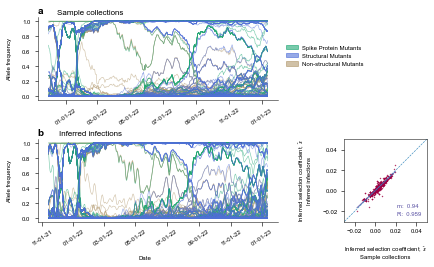

In [4]:
def plot_covar_exp(ax, x, y, z, plot_label, scalar_map):
    # set font param
    mpl.rc('font', family='Arial')
    
    # load in reference site data
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    # labeling nucleotides in npz file
    new_labels = []
    NUC = ['-', 'A', 'C', 'G', 'T']
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)        
    
    # reference genome labeling and filtering
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')
    
    # finding indices of reference sites (based on needle-haystack approach)
    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]
    
    # converting times into dates
    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    # plot trajectories
    num_lines = y.shape[1]
    
    ''' for loop for spectrum color bar: comment out if needed '''
    '''
    for i in range(num_lines):
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            color = scalar_map.to_rgba(i)
            ax.plot(x_dates, y_line, linewidth=1.4, color=color)
    '''
    
    ''' for loop for binary spike legend: comment out if needed '''  
    
    for i in range(num_lines):
        site_label = new_labels[i]
        # handles reference genome insertion characters (22203a-y)
        if isinstance(site_label, str):
            site_value = int(re.sub(r'\D', '', site_label))
        else:
            site_value = int(site_label)
        
        ### comment one or other out
        # binary based on spike protein sites
        #col = 'xkcd:viridian' if (21562 <= site_value < 25384) else 'xkcd:grayish purple'
        if (21562 <= site_value < 25384):
            col = 'xkcd:jade'
        elif (25384 <= site_value):
            col = 'xkcd:cornflower blue'
        # binary based on structural sites
        #col = 'xkcd:cobalt blue' if (21562 <= site_value) else 'xkcd:orchid'
        else: col = 'xkcd:dust'
        #col = 'xkcd:viridian' if (21562 <= site_value) else 'xkcd:grayish purple'
        
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            ax.plot(x_dates, y_line, linewidth=0.6, color=col, alpha=0.6)
    
    ax.set_ylabel('Allele frequency', font='Arial', size=6, labelpad=10)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', rotation=35, labelsize=6, width=0.6)
    #ax.tick_params(axis='x', rotation=45, labelsize=6, width=0.6)
    ax.tick_params(axis='y', labelsize=6, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
        
    plt.setp(ax.get_xticklabels(), ha='center')
    
    ax.set_title(plot_label, x=0.22, y=0.97, fontsize=8)
    #ax.set_title(plot_label, x=0.4, y=0.32, fontsize=8)
    
def supp_figure_tricolor(index, home_dir):
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    # from inf_figure function
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])

    fig = plt.figure(figsize=(DOUBLE_COLUMN, DOUBLE_COLUMN/2))
    #gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.5)
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.48)
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot

    
    
    ax1.set_xlabel('a', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax2.set_xlabel('b', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')

    plot_covar_exp(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', None)
    plot_covar_exp(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', None)
    
    plot_inf_supp(ax3, un_sel, bp_sel, index)
    
    # legend, custom
    
    spike_patch = mpatches.Patch(color='xkcd:jade', alpha=0.6, label='Spike Protein Mutants')
    struct_patch = mpatches.Patch(color='xkcd:cornflower blue', alpha=0.6, label='Structural Mutants')
    nonstruct_patch = mpatches.Patch(color='xkcd:dust', alpha=0.6, label='Non-structural Mutants')
    handles = [spike_patch, struct_patch, nonstruct_patch]

    #fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.22, 0.5), ncol=1, frameon=False,fontsize=6)  # Legend on the right side
    
    fig.legend(handles=handles, loc='center right', bbox_to_anchor=(0.75, 0.75), ncol=1, fontsize=6, frameon=False)  # Legend on the right side
    
    
    
    #fig.supxlabel('Date', fontsize=6, y=-0.12, x=0.52)
    
    #plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.9, hspace=0.9)



    #fig.supxlabel('Date', fontsize=6, y=-0.10, x=0.51)
    fig.supxlabel('Date', fontsize=6, y=-0.05, x=0.31)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.8)
    
    #save_path = f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/supplementary_case_{index}_tri.pdf'
    #print(f"saving plot to: {save_path}")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return fig

fig = supp_figure_tricolor(15, home_dir)

Enter the start value as integer or 0 for entire trajectory: 0
Enter the end value as integer or 0 for entire trajectory: 0
LinregressResult(slope=0.958545529419577, intercept=7.269121948922871e-06, rvalue=0.7839594258550259, pvalue=0.0, stderr=0.016321160959358417, intercept_stderr=2.7240686648598915e-05)


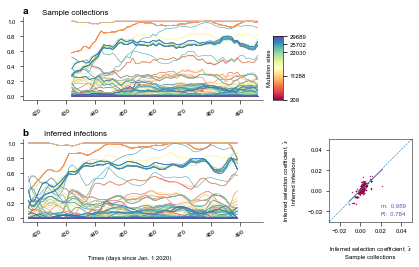

In [5]:
def plot_times_covar(ax, x, y, z, plot_label, start_time, end_time, scalar_map):
    
    # set font param
    mpl.rc('font', family='Arial')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]

    #ref_date = datetime.date(2020, 1, 1)
    #x_days = [int(day) for day in x]
    #x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    num_lines = y.shape[1]

    for i in range(num_lines):
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            color = scalar_map.to_rgba(i)
            #ax.plot(x_dates, y_line, linewidth=1.4, color=color)
            ax.plot(x_line, y_line, linewidth=0.6, color=color)
    plt.subplots_adjust(bottom=0.15)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', labelsize=6, rotation=35, width=0.6)
    ax.tick_params(axis='y', labelsize=6, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')

    #fig.autofmt_xdate()
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    
    plt.setp(ax.get_xticklabels(), ha='center')
    
    ax.set_xlim(start_time, end_time)
    
    ax.set_title(plot_label, x=0.22, y=0.97, fontsize=8)

def supp_figure_times(index, home_dir):
    
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    # from inf_figure function
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    # gridspec parameters
    
    fig = plt.figure(figsize=(DOUBLE_COLUMN, DOUBLE_COLUMN/2))
    #gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.5)
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.48)
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot
    
    ax1.set_xlabel('a', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax2.set_xlabel('b', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')

    num_lines = un_sel_y.shape[1]
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    start = int(input("Enter the start value as integer or 0 for entire trajectory: "))
    end = int(input("Enter the end value as integer or 0 for entire trajectory: "))
    
    if start == 0:
        start = min(min(un_sel_x), min(bp_sel_x)) - 2
    if end == 0:
        end = max(max(un_sel_x), max(bp_sel_x)) + 2

    plot_times_covar(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', start, end, scalar_map)
    plot_times_covar(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', start, end, scalar_map)
    
    plot_inf_supp(ax3, un_sel, bp_sel, index)
    
    # shared colorbar (next to ax1)
    ref_sites = extract_numeric(un_ref_z)
    percentiles = np.percentile(ref_sites, [0, 25, 50, 75, 100])
    norm_cbar = Normalize(vmin=min(ref_sites), vmax=max(ref_sites))
    scalar_map = cm.ScalarMappable(norm=norm_cbar, cmap=cmap)
    cax = fig.add_axes([0.59, 0.578, 0.02, 0.25])
    #cax = fig.add_axes([0.94, 0.4, 0.02, 0.25])
    cbar = fig.colorbar(scalar_map, cax=cax)
    
    cbar.set_label('Mutation sites', font='Arial', size=6, labelpad=-40)
    cbar.set_ticks(percentiles)
    cbar.set_ticklabels([f'{int(p)}' for p in percentiles])
    cbar.outline.set_linewidth(0.6)

    for label in cbar.ax.get_yticklabels():
        label.set_fontname('Arial')
        label.set_fontsize(6)
    
    #is_consecutive = all(un_sel_x[i] == un_sel_x[i-1] + 1 for i in range(1, len(un_sel_x)))
    #is_bp_consecutive = all(bp_sel_x[i] == bp_sel_x[i-1] + 1 for i in range(1, len(bp_sel_x)))
    #print(is_consecutive, is_bp_consecutive)
        
        #fig.supxlabel('Date', fontsize=6, y=-0.10, x=0.51)
    fig.supxlabel('Times (days since Jan. 1 2020)', fontsize=6, y=-0.05, x=0.31)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.8)
    
    #save_path = f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/supplementary_case_{index}_color_rescale.pdf'
    #print(f"saving plot to: {save_path}")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

fig = supp_figure_times(100, home_dir)

Enter the start date as integer or 0 for entire trajectory: 0
Enter the end date as integer or 0 for entire trajectory: 0
LinregressResult(slope=0.6605437580718485, intercept=0.00012252112151728145, rvalue=0.6989334093554568, pvalue=0.0, stderr=0.012654190475968139, intercept_stderr=2.4276190152203905e-05)


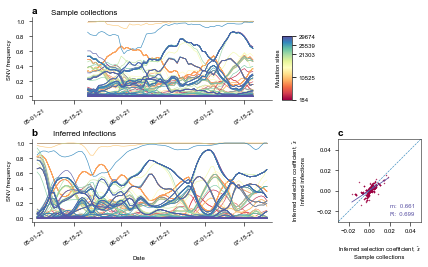

In [6]:
def plot_rescale_dates_covar(ax, x, y, z, plot_label, start_time, end_time, scalar_map):
    
    # set font param
    mpl.rc('font', family='Arial')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]

    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    num_lines = y.shape[1]

    for i in range(num_lines):
        if i not in indices:
            #x_line = x
            y_line = y[:, i]
            color = scalar_map.to_rgba(i)
            ax.plot(x_dates, y_line, linewidth=0.6, color=color)
            #ax.plot(x_line, y_line, linewidth=0.6, color=color)
    plt.subplots_adjust(bottom=0.15)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', labelsize=6, rotation=35, width=0.6)
    ax.tick_params(axis='y', labelsize=6, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')

    #fig.autofmt_xdate()
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    
    plt.setp(ax.get_xticklabels(), ha='center')
    
    start_date = ref_date + datetime.timedelta(int(start_time))
    end_date = ref_date + datetime.timedelta(int(end_time))
    
    ax.set_xlim(start_date, end_date)
    
    ax.set_title(plot_label, x=0.22, y=0.97, fontsize=8)

def supp_figure_rescale_dates(index, home_dir):
    
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    # from inf_figure function
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    # gridspec parameters
    
    fig = plt.figure(figsize=(DOUBLE_COLUMN, DOUBLE_COLUMN/2))
    #gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.5)
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.48)
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot
    
    ax1.set_xlabel('a', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax2.set_xlabel('b', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')
    
    ax1.set_ylabel('SNV frequency', font='Arial', size=6)
    ax2.set_ylabel('SNV frequency', font='Arial', size=6)
    
    #ax3.set_xlabel('c', font='Arial', fontweight='bold', size=10, labelpad=20, loc='left')
    #ax3.xaxis.set_label_position('top')

    num_lines = un_sel_y.shape[1]
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    start = int(input("Enter the start date as integer or 0 for entire trajectory: "))
    end = int(input("Enter the end date as integer or 0 for entire trajectory: "))
    
    if start == 0:
        start = min(min(un_sel_x), min(bp_sel_x)) - 2 # 10 for longer traj to make fig look nice
    if end == 0:
        end = max(max(un_sel_x), max(bp_sel_x)) + 2

    plot_rescale_dates_covar(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', start, end, scalar_map)
    plot_rescale_dates_covar(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', start, end, scalar_map)
    
    plot_inf_supp(ax3, un_sel, bp_sel, index)
    
    # shared colorbar (next to ax1)
    ref_sites = extract_numeric(un_ref_z)
    percentiles = np.percentile(ref_sites, [0, 25, 50, 75, 100])
    norm_cbar = Normalize(vmin=min(ref_sites), vmax=max(ref_sites))
    scalar_map = cm.ScalarMappable(norm=norm_cbar, cmap=cmap)
    cax = fig.add_axes([0.59, 0.578, 0.02, 0.25])
    #cax = fig.add_axes([0.94, 0.4, 0.02, 0.25])
    cbar = fig.colorbar(scalar_map, cax=cax)
    
    cbar.set_label('Mutation sites', font='Arial', size=6, labelpad=-40)
    cbar.set_ticks(percentiles)
    cbar.set_ticklabels([f'{int(p)}' for p in percentiles])
    cbar.outline.set_linewidth(0.6)

    for label in cbar.ax.get_yticklabels():
        label.set_fontname('Arial')
        label.set_fontsize(6)
    
    #is_consecutive = all(un_sel_x[i] == un_sel_x[i-1] + 1 for i in range(1, len(un_sel_x)))
    #is_bp_consecutive = all(bp_sel_x[i] == bp_sel_x[i-1] + 1 for i in range(1, len(bp_sel_x)))
    #print(is_consecutive, is_bp_consecutive)
        
        #fig.supxlabel('Date', fontsize=6, y=-0.10, x=0.51)
    #fig.supxlabel('Times (days since Jan. 1 2020)', fontsize=6, y=-0.05, x=0.31)
    fig.supxlabel('Date', fontsize=6, y=-0.05, x=0.31)
    fig.supylabel('c', font='Arial', fontweight='bold', fontsize=10, y=0.45, x=0.70,rotation=0)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.8)
    
    #save_path = f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/supplementary_case_{index}_color_date_rescale_3.pdf'
    #print(f"saving plot to: {save_path}")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return fig

fig = supp_figure_rescale_dates(76, home_dir)

In [5]:
from matplotlib.lines import Line2D
def plot_inf_supp(ax, x, y, index):
    mpl.rc('font', family='Avenir')

    ax.plot(x, y, 'o', color=rgba1, markersize=0.6)

    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color=rgba6, linewidth=1.2)

    #ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 2))(np.unique(x)), color='xkcd:vermillion', linewidth=0.8)

    
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color=rgba5, linestyle='dashed', linewidth=1.2)

    ax.set_xlim(xmin=-0.03, xmax=0.05)
    ax.set_ylim(ymin=-0.03, ymax=0.05)

    x_title = 'Inferred selection coefficient, ' + r'$\hat{s}$' + '\nSample collections'
    y_title = 'Inferred selection coefficient, ' + r'$\hat{s}$' + '\nInferred infections'
    ax.set_xlabel(xlabel=x_title, font='Avenir', size=12, labelpad=5, math_fontfamily='stixsans')
    ax.set_ylabel(ylabel=y_title, font='Avenir', size=12, labelpad=5, math_fontfamily='stixsans')

    ax.set_aspect('equal', adjustable='box')
    ax.tick_params(axis='x', labelsize=12, width=0.6)
    ax.tick_params(axis='y', labelsize=12, width=0.6)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Avenir')
        
    for line in ['top', 'right']:
        ax.spines[line].set_linewidth(0.5)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
        
    lr = linregress(x, y)
        
    custom_shapes = [Line2D([0], [0], marker='o', color='w', alpha=0),
                     Line2D([0], [0], marker='o', color='w', alpha=0)]    
    custom_labels = ['m:  ' + str(round(lr.slope, 3)), 'R:  ' + str(round(lr.rvalue, 3))]
    
    ax.legend(custom_shapes, custom_labels, loc='lower right', fontsize=12, labelcolor=rgba6, frameon=False)

    #for t in leg.get_texts():
    #    t.set_ha('left')
    
    
    print(linregress(x, y))

Enter the start date as integer or 0 for entire trajectory: 0
Enter the end date as integer or 0 for entire trajectory: 0
LinregressResult(slope=0.9404216615373164, intercept=0.00015832998893173362, rvalue=0.9593123716055136, pvalue=0.0, stderr=0.00555465701394936, intercept_stderr=2.1766032616172233e-05)
saving plot to: /Users/liz/Documents/GitHub/paper-epi-backprojection/figures/thesis_15_pad.pdf


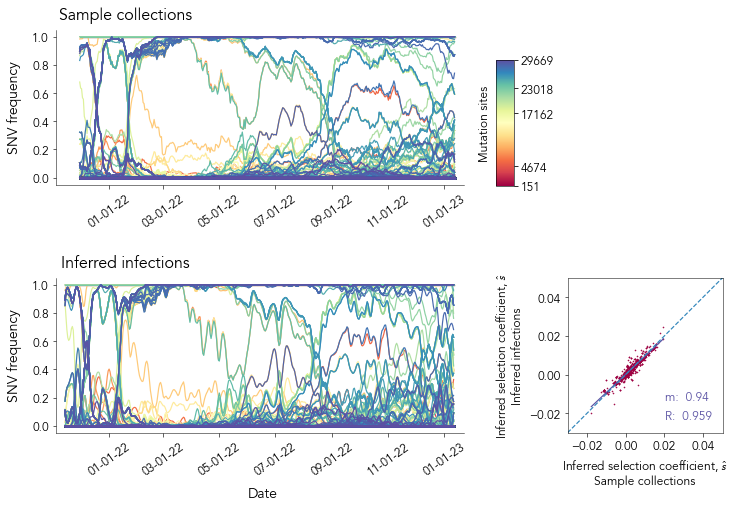

In [60]:
def plot_rescale_dates_covar(ax, x, y, z, plot_label, start_time, end_time, scalar_map):
    
    # set font param
    mpl.rc('font', family='Avenir')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]

    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    num_lines = y.shape[1]

    for i in range(num_lines):
        if i not in indices:
            y_line = y[:, i]
            color = scalar_map.to_rgba(i)
            ax.plot(x_dates, y_line, linewidth=1.2, color=color)
    plt.subplots_adjust(bottom=0.15)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', labelsize=12, rotation=35, width=0.6)
    ax.tick_params(axis='y', labelsize=12, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Avenir')

    #fig.autofmt_xdate()
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    
    plt.setp(ax.get_xticklabels(), ha='center')
    
    start_date = ref_date + datetime.timedelta(int(start_time))
    end_date = ref_date + datetime.timedelta(int(end_time))
    
    ax.set_xlim(start_date, end_date)
    
    ax.set_title(plot_label, x=0.17, y=1.03, fontsize=16)

def supp_figure_rescale_dates(index, home_dir):
    
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    # from inf_figure function
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    # gridspec parameters
    
    fig = plt.figure(figsize=(12, 7))
    #gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.5)
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.6)
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot
    
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')
    
    ax1.set_ylabel('SNV frequency', font='Avenir', size=14, labelpad=10)
    ax2.set_ylabel('SNV frequency', font='Avenir', size=14, labelpad=10)

    num_lines = un_sel_y.shape[1]
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    start = int(input("Enter the start date as integer or 0 for entire trajectory: "))
    end = int(input("Enter the end date as integer or 0 for entire trajectory: "))
    
    if start == 0:
        start = min(min(un_sel_x), min(bp_sel_x)) - 10 # 10 for longer traj to make fig look nice
    if end == 0:
        end = max(max(un_sel_x), max(bp_sel_x)) + 10

    plot_rescale_dates_covar(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', start, end, scalar_map)
    plot_rescale_dates_covar(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', start, end, scalar_map)
    
    plot_inf_supp(ax3, un_sel, bp_sel, index)
    
    # shared colorbar (next to ax1)
    ref_sites = extract_numeric(un_ref_z)
    percentiles = np.percentile(ref_sites, [0, 25, 50, 75, 100])
    norm_cbar = Normalize(vmin=min(ref_sites), vmax=max(ref_sites))
    scalar_map = cm.ScalarMappable(norm=norm_cbar, cmap=cmap)
    #cax = fig.add_axes([0.59, 0.578, 0.02, 0.25])
    cax = fig.add_axes([0.61, 0.59, 0.02, 0.25])
    #cax = fig.add_axes([0.94, 0.4, 0.02, 0.25])
    cbar = fig.colorbar(scalar_map, cax=cax)
    
    cbar.set_label('Mutation sites', font='Avenir', size=12, labelpad=-75)
    cbar.set_ticks(percentiles)
    cbar.set_ticklabels([f'{int(p)}' for p in percentiles])
    cbar.outline.set_linewidth(0.6)

    for label in cbar.ax.get_yticklabels():
        label.set_fontname('Avenir')
        label.set_fontsize(12)
    
    fig.supxlabel('Date', fontsize=14, y=-0.035, x=0.34)

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=1)
    
    save_path = f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/thesis_{index}_pad.pdf'
    print(f"saving plot to: {save_path}")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    #plt.show()
    return fig

fig = supp_figure_rescale_dates(15, home_dir)

Enter the start date as integer or 0 for entire trajectory: 1010
Enter the end date as integer or 0 for entire trajectory: 1070
LinregressResult(slope=1.0596962732949253, intercept=-0.0001505687668090891, rvalue=0.9144415853630241, pvalue=0.0, stderr=0.010401816159541605, intercept_stderr=5.09342227615404e-05)


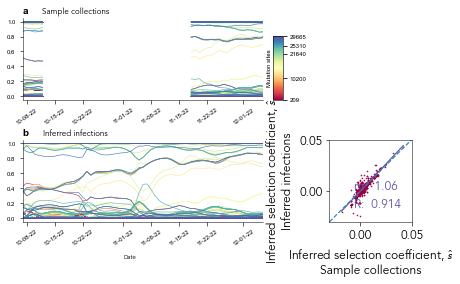

In [8]:
def plot_gaps_rescale_dates_covar(ax, x, y, z, plot_label, start_time, end_time, scalar_map):
    
    # set font param
    mpl.rc('font', family='Arial')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]

    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    # masking procedure is manual
    # redo for times?
    ################
    # plot 08    
    #mask_start = datetime.date(2022, 9, 30)
    #mask_end = datetime.date(2022, 10, 5)
    #mask_start_2 = datetime.date(2022, 7, 29)
    #mask_end_2 = datetime.date(2022, 8, 4)
    
    #################
    # plot 38
    #mask_start = datetime.date(2022, 12, 9)
    #mask_end = datetime.date(2022, 12, 13)
    
    ###########################
    # plot 44
    #mask_start = datetime.date(2022, 7, 2)
    #mask_end = datetime.date(2022, 7, 20)
    
    ############################
    # plot 55
    #mask_start = datetime.date(2021, 4, 28)
    #mask_end = datetime.date(2021, 6, 3)
    
    #################################
    # plot 53 (unprocessed)
    
    mask_start = datetime.date(2021, 4, 23)
    mask_end = datetime.date(2021, 5, 3)
    mask_start_2 = datetime.date(2021, 5, 15)
    mask_end_2 = datetime.date(2021, 5, 24)
    mask_start_3 = datetime.date(2022, 10, 13)
    mask_end_3 = datetime.date(2022, 11, 17)
    
    masked_y = y.copy()
    for i, date in enumerate(x_dates):
        if mask_start <= date <= mask_end:
            masked_y[i, :] = np.nan
        if mask_start_2 <= date <= mask_end_2:
            masked_y[i, :] = np.nan
        if mask_start_3 <= date <= mask_end_3:
            masked_y[i, :] = np.nan
    ##################
    
    num_lines = y.shape[1]

    for i in range(num_lines):
        if i not in indices:
            #x_line = x
            #y_line = y[:, i]
            y_line = masked_y[:, i]
            color = scalar_map.to_rgba(i)
            ax.plot(x_dates, y_line, linewidth=0.6, color=color)
            #ax.plot(x_line, y_line, linewidth=0.6, color=color)
    plt.subplots_adjust(bottom=0.15)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', labelsize=6, rotation=35, width=0.6)
    ax.tick_params(axis='y', labelsize=6, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')

    #fig.autofmt_xdate()
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    
    plt.setp(ax.get_xticklabels(), ha='center')
    
    start_date = ref_date + datetime.timedelta(int(start_time))
    end_date = ref_date + datetime.timedelta(int(end_time))
    
    ax.set_xlim(start_date, end_date)
    
    ax.set_title(plot_label, x=0.22, y=0.97, fontsize=8)

def plot_gaps_rescale_dates_covar_2(ax, x, y, z, plot_label, start_time, end_time, scalar_map):
    
    # set font param
    mpl.rc('font', family='Arial')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]

    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    # masking procedure is manual
    # redo for times?
    ################
    # plot 08    
    #mask_start = datetime.date(2022, 9, 30)
    #mask_end = datetime.date(2022, 10, 5)
    #mask_start_2 = datetime.date(2022, 7, 29)
    #mask_end_2 = datetime.date(2022, 8, 4)
    
    #################
    # plot 38
    #mask_start = datetime.date(2022, 12, 9)
    #mask_end = datetime.date(2022, 12, 13)
    
    ###########################
    # plot 44
    #mask_start = datetime.date(2022, 7, 2)
    #mask_end = datetime.date(2022, 7, 20)
    
    ############################
    # plot 55
    #mask_start = datetime.date(2021, 4, 28)
    #mask_end = datetime.date(2021, 6, 3)
    
    #################################
    # plot 53 (back projection)
    mask_start = datetime.date(2021, 4, 18)
    mask_end = datetime.date(2021, 4, 20)
    
    masked_y = y.copy()
    for i, date in enumerate(x_dates):
        if mask_start <= date <= mask_end:
            masked_y[i, :] = np.nan
        #if mask_start_2 <= date <= mask_end_2:
        #    masked_y[i, :] = np.nan
    ##################
    
    num_lines = y.shape[1]

    for i in range(num_lines):
        if i not in indices:
            #x_line = x
            #y_line = y[:, i]
            y_line = masked_y[:, i]
            color = scalar_map.to_rgba(i)
            ax.plot(x_dates, y_line, linewidth=0.6, color=color)
            #ax.plot(x_line, y_line, linewidth=0.6, color=color)
    plt.subplots_adjust(bottom=0.15)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', labelsize=6, rotation=35, width=0.6)
    ax.tick_params(axis='y', labelsize=6, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')

    #fig.autofmt_xdate()
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    
    plt.setp(ax.get_xticklabels(), ha='center')
    
    start_date = ref_date + datetime.timedelta(int(start_time))
    end_date = ref_date + datetime.timedelta(int(end_time))
    
    ax.set_xlim(start_date, end_date)
    
    ax.set_title(plot_label, x=0.22, y=0.97, fontsize=8)
    
def supp_figure_gaps_rescale_dates(index, home_dir):
    
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    # from inf_figure function
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    # gridspec parameters
    
    fig = plt.figure(figsize=(DOUBLE_COLUMN, DOUBLE_COLUMN/2))
    #gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.5)
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.48)
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot
    
    ax1.set_xlabel('a', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax2.set_xlabel('b', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')

    num_lines = un_sel_y.shape[1]
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    start = int(input("Enter the start date as integer or 0 for entire trajectory: "))
    end = int(input("Enter the end date as integer or 0 for entire trajectory: "))
    
    if start == 0:
        start = min(min(un_sel_x), min(bp_sel_x)) - 10 # 10 for longer traj to make fig look nice
    if end == 0:
        end = max(max(un_sel_x), max(bp_sel_x)) + 10

    plot_gaps_rescale_dates_covar(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', start, end, scalar_map)
    plot_gaps_rescale_dates_covar_2(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', start, end, scalar_map)
    
    plot_inf_supp(ax3, un_sel, bp_sel, index)
    
    # shared colorbar (next to ax1)
    ref_sites = extract_numeric(un_ref_z)
    percentiles = np.percentile(ref_sites, [0, 25, 50, 75, 100])
    norm_cbar = Normalize(vmin=min(ref_sites), vmax=max(ref_sites))
    scalar_map = cm.ScalarMappable(norm=norm_cbar, cmap=cmap)
    cax = fig.add_axes([0.59, 0.578, 0.02, 0.25])
    #cax = fig.add_axes([0.94, 0.4, 0.02, 0.25])
    cbar = fig.colorbar(scalar_map, cax=cax)
    
    cbar.set_label('Mutation sites', font='Arial', size=6, labelpad=-40)
    cbar.set_ticks(percentiles)
    cbar.set_ticklabels([f'{int(p)}' for p in percentiles])
    cbar.outline.set_linewidth(0.6)

    for label in cbar.ax.get_yticklabels():
        label.set_fontname('Arial')
        label.set_fontsize(6)
    
    #is_consecutive = all(un_sel_x[i] == un_sel_x[i-1] + 1 for i in range(1, len(un_sel_x)))
    #is_bp_consecutive = all(bp_sel_x[i] == bp_sel_x[i-1] + 1 for i in range(1, len(bp_sel_x)))
    #print(is_consecutive, is_bp_consecutive)
        
        #fig.supxlabel('Date', fontsize=6, y=-0.10, x=0.51)
    #fig.supxlabel('Times (days since Jan. 1 2020)', fontsize=6, y=-0.05, x=0.31)
    fig.supxlabel('Date', fontsize=6, y=-0.05, x=0.31)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.8)
    plt.show()
    #save_path = f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/supplementary_case_{index}_color_date_gaps_rescale_trim.pdf'
    #print(f"saving plot to: {save_path}")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig
fig = supp_figure_gaps_rescale_dates(53, home_dir)

Enter the start date as integer or 0 for entire trajectory: 0
Enter the end date as integer or 0 for entire trajectory: 0
LinregressResult(slope=0.22604596634105087, intercept=-0.0003527619247271146, rvalue=0.1942540399126634, pvalue=1.3002190792149365e-20, stderr=0.024048806840280577, intercept_stderr=3.562751622041936e-05)


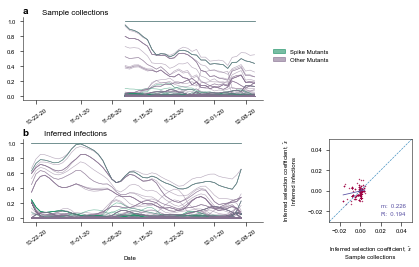

In [4]:
def plot_rescale_dates_covar_spike(ax, x, y, z, plot_label, start_time, end_time, scalar_map):
    
    # set font param
    mpl.rc('font', family='Arial')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]

    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    num_lines = y.shape[1]
    
    for i in range(num_lines):
        site_label = new_labels[i]
        # handles reference genome insertion characters (22203a-y)
        if isinstance(site_label, str):
            site_value = int(re.sub(r'\D', '', site_label))
        else:
            site_value = int(site_label)
        
        ### comment one or other out
        # binary based on spike protein sites
        col = 'xkcd:viridian' if (21562 <= site_value < 25384) else 'xkcd:grayish purple'
        
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            ax.plot(x_dates, y_line, linewidth=0.6, color=col, alpha=0.6)

    #plt.subplots_adjust(bottom=0.15)
    
    #ax.set_ylabel('Allele frequency', font='Arial', size=6, labelpad=10)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', labelsize=6, rotation=35, width=0.6)
    ax.tick_params(axis='y', labelsize=6, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')

    #fig.autofmt_xdate()
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    
    plt.setp(ax.get_xticklabels(), ha='center')
    
    start_date = ref_date + datetime.timedelta(int(start_time))
    end_date = ref_date + datetime.timedelta(int(end_time))
    
    ax.set_xlim(start_date, end_date)
    
    ax.set_title(plot_label, x=0.22, y=0.97, fontsize=8)

def supp_figure_rescale_dates_spike(index, home_dir):
    
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    # from inf_figure function
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    # gridspec parameters
    
    fig = plt.figure(figsize=(DOUBLE_COLUMN, DOUBLE_COLUMN/2))
    #gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.5)
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.48)
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot
    
    ax1.set_xlabel('a', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax2.set_xlabel('b', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')

    num_lines = un_sel_y.shape[1]
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    start = int(input("Enter the start date as integer or 0 for entire trajectory: "))
    end = int(input("Enter the end date as integer or 0 for entire trajectory: "))
    
    if start == 0:
        start = min(min(un_sel_x), min(bp_sel_x)) - 2 # 10 for longer traj to make fig look nice
    if end == 0:
        end = max(max(un_sel_x), max(bp_sel_x)) + 2

    plot_rescale_dates_covar_spike(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', start, end, scalar_map)
    plot_rescale_dates_covar_spike(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', start, end, scalar_map)
    
    plot_inf_supp(ax3, un_sel, bp_sel, index)
    
    # legend, custom
    
    spike_patch = mpatches.Patch(color='xkcd:viridian', label='Spike Mutants', alpha = 0.6)
    other_patch = mpatches.Patch(color='xkcd:grayish purple', label='Other Mutants', alpha = 0.6)
    handles = [spike_patch, other_patch]

    #fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.22, 0.5), ncol=1, frameon=False,fontsize=6)  # Legend on the right side
    
    fig.legend(handles=handles, loc='center right', bbox_to_anchor=(0.71, 0.75), ncol=1, fontsize=6, frameon=False)  # Legend on the right side

    fig.supxlabel('Date', fontsize=6, y=-0.05, x=0.31)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.8)
    
    #save_path = f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/supplementary_case_{index}_spike_date_rescale.pdf'
    #print(f"saving plot to: {save_path}")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

fig = supp_figure_rescale_dates_spike(54, home_dir)

Enter the start date as integer or 0 for entire trajectory: 0
Enter the end date as integer or 0 for entire trajectory: 0
LinregressResult(slope=1.1262414907354423, intercept=-8.054130365389635e-05, rvalue=0.6414395910847149, pvalue=2.2479786629532934e-142, stderr=0.038596305552672974, intercept_stderr=6.0496363540649907e-05)
saving plot to: /Users/liz/Documents/GitHub/paper-epi-backprojection/figures/supplementary_case_33_tricolor_date_rescale_double.pdf


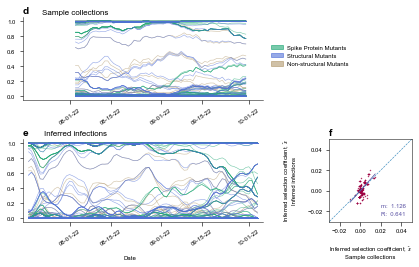

In [91]:
def plot_rescale_dates_covar_tricolor(ax, x, y, z, plot_label, start_time, end_time, scalar_map):
    
    # set font param
    mpl.rc('font', family='Arial')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]

    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    num_lines = y.shape[1]
    
    for i in range(num_lines):
        site_label = new_labels[i]
        # handles reference genome insertion characters (22203a-y)
        if isinstance(site_label, str):
            site_value = int(re.sub(r'\D', '', site_label))
        else:
            site_value = int(site_label)
        
        ### comment one or other out
        # binary based on spike protein sites
        #col = 'xkcd:viridian' if (21562 <= site_value < 25384) else 'xkcd:grayish purple'
        if (21562 <= site_value < 25384):
            col = 'xkcd:jade'
        elif (25384 <= site_value):
            col = 'xkcd:cornflower blue'
        # binary based on structural sites
        #col = 'xkcd:cobalt blue' if (21562 <= site_value) else 'xkcd:orchid'
        else: col = 'xkcd:dust'
        #col = 'xkcd:viridian' if (21562 <= site_value) else 'xkcd:grayish purple'
        
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            ax.plot(x_dates, y_line, linewidth=0.6, color=col, alpha=0.6)

    #plt.subplots_adjust(bottom=0.15)
    
    #ax.set_ylabel('Allele frequency', font='Arial', size=6, labelpad=10)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', labelsize=6, rotation=35, width=0.6)
    ax.tick_params(axis='y', labelsize=6, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')

    #fig.autofmt_xdate()
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    
    plt.setp(ax.get_xticklabels(), ha='center')
    
    start_date = ref_date + datetime.timedelta(int(start_time))
    end_date = ref_date + datetime.timedelta(int(end_time))
    
    ax.set_xlim(start_date, end_date)
    
    ax.set_title(plot_label, x=0.22, y=0.97, fontsize=8)

def supp_figure_rescale_dates_tricolor(index, home_dir):
    
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    # from inf_figure function
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    # gridspec parameters
    
    fig = plt.figure(figsize=(DOUBLE_COLUMN, DOUBLE_COLUMN/2))
    #gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.5)
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.48)
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot
    
    ax1.set_xlabel('d', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax2.set_xlabel('e', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')

    num_lines = un_sel_y.shape[1]
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    start = int(input("Enter the start date as integer or 0 for entire trajectory: "))
    end = int(input("Enter the end date as integer or 0 for entire trajectory: "))
    
    if start == 0:
        start = min(min(un_sel_x), min(bp_sel_x)) - 2 # 10 for longer traj to make fig look nice
    if end == 0:
        end = max(max(un_sel_x), max(bp_sel_x)) + 2

    plot_rescale_dates_covar_tricolor(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', start, end, scalar_map)
    plot_rescale_dates_covar_tricolor(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', start, end, scalar_map)
    
    plot_inf_supp(ax3, un_sel, bp_sel, index)
    
    # custom legend
    
    spike_patch = mpatches.Patch(color='xkcd:jade', alpha=0.6, label='Spike Protein Mutants')
    struct_patch = mpatches.Patch(color='xkcd:cornflower blue', alpha=0.6, label='Structural Mutants')
    nonstruct_patch = mpatches.Patch(color='xkcd:dust', alpha=0.6, label='Non-structural Mutants')
    handles = [spike_patch, struct_patch, nonstruct_patch]

    #fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.22, 0.5), ncol=1, frameon=False,fontsize=6)  # Legend on the right side
    
    fig.legend(handles=handles, loc='center right', bbox_to_anchor=(0.75, 0.75), ncol=1, fontsize=6, frameon=False)  # Legend on the right side
    
    fig.supxlabel('Date', fontsize=6, y=-0.05, x=0.31)
    fig.supylabel('f', font='Arial', fontweight='bold', fontsize=10, y=0.45, x=0.70,rotation=0)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.8)
    
    save_path = f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/supplementary_case_{index}_tricolor_date_rescale_double.pdf'
    print(f"saving plot to: {save_path}")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

fig = supp_figure_rescale_dates_tricolor(33, home_dir)

Enter the start date as integer or 0 for entire trajectory: 0
Enter the end date as integer or 0 for entire trajectory: 0
LinregressResult(slope=0.9532976210556817, intercept=0.00014691935322288488, rvalue=0.9757773551497271, pvalue=0.0, stderr=0.0033065366345695255, intercept_stderr=1.405146248148668e-05)
saving plot to: /Users/liz/Documents/GitHub/paper-epi-backprojection/figures/supplementary_case_38_slovakia.pdf


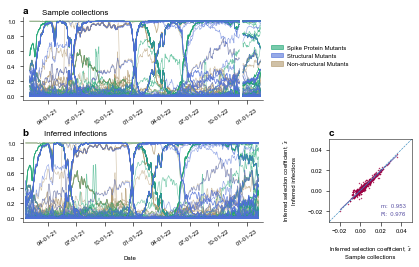

In [92]:
def plot_rescale_dates_covar_tricolor_gaps(ax, x, y, z, plot_label, start_time, end_time, scalar_map):
    
    # set font param
    mpl.rc('font', family='Arial')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]

    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 

    
    # masking procedure is manual
    # redo for times?
    ################
    # plot 08    
    #mask_start = datetime.date(2022, 9, 30)
    #mask_end = datetime.date(2022, 10, 5)
    #mask_start_2 = datetime.date(2022, 7, 29)
    #mask_end_2 = datetime.date(2022, 8, 4)
    
    #################
    # plot 38
    mask_start = datetime.date(2022, 12, 9)
    mask_end = datetime.date(2022, 12, 13)
    
    ###########################
    # plot 44
    #mask_start = datetime.date(2022, 7, 2)
    #mask_end = datetime.date(2022, 7, 20)
    
    ############################
    # plot 55
    #mask_start = datetime.date(2021, 4, 28)
    #mask_end = datetime.date(2021, 6, 3)
    

    masked_y = y.copy()
    for i, date in enumerate(x_dates):
        if mask_start <= date <= mask_end:
            masked_y[i, :] = np.nan
        #if mask_start_2 <= date <= mask_end_2:
        #    masked_y[i, :] = np.nan
    ##################
    
    num_lines = y.shape[1]
    
    for i in range(num_lines):
        site_label = new_labels[i]
        # handles reference genome insertion characters (22203a-y)
        if isinstance(site_label, str):
            site_value = int(re.sub(r'\D', '', site_label))
        else:
            site_value = int(site_label)
        
        ### comment one or other out
        # binary based on spike protein sites
        #col = 'xkcd:viridian' if (21562 <= site_value < 25384) else 'xkcd:grayish purple'
        if (21562 <= site_value < 25384):
            col = 'xkcd:jade'
        elif (25384 <= site_value):
            col = 'xkcd:cornflower blue'
        # binary based on structural sites
        #col = 'xkcd:cobalt blue' if (21562 <= site_value) else 'xkcd:orchid'
        else: col = 'xkcd:dust'
        #col = 'xkcd:viridian' if (21562 <= site_value) else 'xkcd:grayish purple'
        
        if i not in indices:
            x_line = x
            y_line = masked_y[:, i]
            ax.plot(x_dates, y_line, linewidth=0.6, color=col, alpha=0.6)

    #plt.subplots_adjust(bottom=0.15)
    
    #ax.set_ylabel('Allele frequency', font='Arial', size=6, labelpad=10)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', labelsize=6, rotation=35, width=0.6)
    ax.tick_params(axis='y', labelsize=6, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')

    #fig.autofmt_xdate()
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    
    plt.setp(ax.get_xticklabels(), ha='center')
    
    start_date = ref_date + datetime.timedelta(int(start_time))
    end_date = ref_date + datetime.timedelta(int(end_time))
    
    ax.set_xlim(start_date, end_date)
    
    ax.set_title(plot_label, x=0.22, y=0.97, fontsize=8)

def supp_figure_rescale_dates_tricolor_gaps(index, home_dir):
    
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    # from inf_figure function
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    # gridspec parameters
    
    fig = plt.figure(figsize=(DOUBLE_COLUMN, DOUBLE_COLUMN/2))
    #gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.5)
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.48)
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot
    
    ax1.set_xlabel('a', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax2.set_xlabel('b', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')

    num_lines = un_sel_y.shape[1]
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    start = int(input("Enter the start date as integer or 0 for entire trajectory: "))
    end = int(input("Enter the end date as integer or 0 for entire trajectory: "))
    
    if start == 0:
        start = min(min(un_sel_x), min(bp_sel_x)) - 10 # 10 for longer traj to make fig look nice
    if end == 0:
        end = max(max(un_sel_x), max(bp_sel_x)) + 10

    plot_rescale_dates_covar_tricolor_gaps(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', start, end, scalar_map)
    plot_rescale_dates_covar_tricolor(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', start, end, scalar_map)
    
    plot_inf_supp(ax3, un_sel, bp_sel, index)
    
    # custom legend
    
    spike_patch = mpatches.Patch(color='xkcd:jade', alpha=0.6, label='Spike Protein Mutants')
    struct_patch = mpatches.Patch(color='xkcd:cornflower blue', alpha=0.6, label='Structural Mutants')
    nonstruct_patch = mpatches.Patch(color='xkcd:dust', alpha=0.6, label='Non-structural Mutants')
    handles = [spike_patch, struct_patch, nonstruct_patch]

    #fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.22, 0.5), ncol=1, frameon=False,fontsize=6)  # Legend on the right side
    
    fig.legend(handles=handles, loc='center right', bbox_to_anchor=(0.75, 0.75), ncol=1, fontsize=6, frameon=False)  # Legend on the right side
    
    fig.supxlabel('Date', fontsize=6, y=-0.05, x=0.31)
    fig.supylabel('c', font='Arial', fontweight='bold', fontsize=10, y=0.45, x=0.70,rotation=0)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.8)
    
    save_path = f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/supplementary_case_{index}_slovakia.pdf'
    print(f"saving plot to: {save_path}")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

fig = supp_figure_rescale_dates_tricolor_gaps(38, home_dir)

Enter the start date as integer or 0 for entire trajectory: 652
Enter the end date as integer or 0 for entire trajectory: 700
LinregressResult(slope=0.955276591778143, intercept=0.0006223131876729804, rvalue=0.8204990361436986, pvalue=0.0, stderr=0.013479160020083526, intercept_stderr=5.0958298119301085e-05)


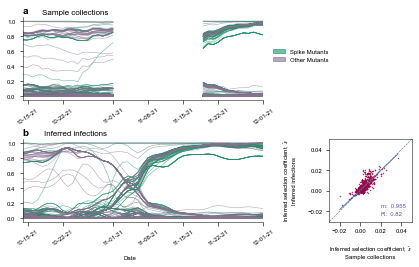

In [9]:
def plot_rescale_dates_covar_spike_gaps(ax, x, y, z, plot_label, start_time, end_time, scalar_map):
    
    # set font param
    mpl.rc('font', family='Arial')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]

    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 

    
    # masking procedure is manual
    # redo for times?
    ################
    # plot 08    
    #mask_start = datetime.date(2022, 9, 30)
    #mask_end = datetime.date(2022, 10, 5)
    #mask_start_2 = datetime.date(2022, 7, 29)
    #mask_end_2 = datetime.date(2022, 8, 4)
    
    #plot 11 (South Africa supplementary figure)
    mask_start = datetime.date(2021, 11, 2)
    mask_end = datetime.date(2021, 11, 18)
    
    #################
    # plot 38
    #mask_start = datetime.date(2022, 12, 9)
    #mask_end = datetime.date(2022, 12, 13)
    
    ###########################
    # plot 44
    #mask_start = datetime.date(2022, 7, 2)
    #mask_end = datetime.date(2022, 7, 20)
    
    ############################
    # plot 55
    #mask_start = datetime.date(2021, 4, 28)
    #mask_end = datetime.date(2021, 6, 3)
    

    masked_y = y.copy()
    for i, date in enumerate(x_dates):
        if mask_start <= date <= mask_end:
            masked_y[i, :] = np.nan
        #if mask_start_2 <= date <= mask_end_2:
        #    masked_y[i, :] = np.nan
    ##################
    
    num_lines = y.shape[1]
    
    for i in range(num_lines):
        site_label = new_labels[i]
        # handles reference genome insertion characters (22203a-y)
        if isinstance(site_label, str):
            site_value = int(re.sub(r'\D', '', site_label))
        else:
            site_value = int(site_label)
        
        ### comment one or other out
        # binary based on spike protein sites
        col = 'xkcd:viridian' if (21562 <= site_value < 25384) else 'xkcd:grayish purple'
        
        if i not in indices:
            x_line = x
            y_line = masked_y[:, i]
            ax.plot(x_dates, y_line, linewidth=0.6, color=col, alpha=0.6)

    #plt.subplots_adjust(bottom=0.15)
    
    #ax.set_ylabel('Allele frequency', font='Arial', size=6, labelpad=10)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', labelsize=6, rotation=35, width=0.6)
    ax.tick_params(axis='y', labelsize=6, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')

    #fig.autofmt_xdate()
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    
    plt.setp(ax.get_xticklabels(), ha='center')
    
    start_date = ref_date + datetime.timedelta(int(start_time))
    end_date = ref_date + datetime.timedelta(int(end_time))
    
    ax.set_xlim(start_date, end_date)
    
    ax.set_title(plot_label, x=0.22, y=0.97, fontsize=8)

def supp_figure_rescale_dates_spike_gaps(index, home_dir):
    
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    # from inf_figure function
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    # gridspec parameters
    
    fig = plt.figure(figsize=(DOUBLE_COLUMN, DOUBLE_COLUMN/2))
    #gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.5)
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.48)
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot
    
    ax1.set_xlabel('a', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax2.set_xlabel('b', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')

    num_lines = un_sel_y.shape[1]
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    start = int(input("Enter the start date as integer or 0 for entire trajectory: "))
    end = int(input("Enter the end date as integer or 0 for entire trajectory: "))
    
    if start == 0:
        start = min(min(un_sel_x), min(bp_sel_x)) - 2 # 10 for longer traj to make fig look nice
    if end == 0:
        end = max(max(un_sel_x), max(bp_sel_x)) + 2

    plot_rescale_dates_covar_spike_gaps(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', start, end, scalar_map)
    plot_rescale_dates_covar_spike(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', start, end, scalar_map)
    
    plot_inf_supp(ax3, un_sel, bp_sel, index)
    
    # custom legend
    
    
    spike_patch = mpatches.Patch(color='xkcd:viridian', label='Spike Mutants', alpha = 0.6)
    other_patch = mpatches.Patch(color='xkcd:grayish purple', label='Other Mutants', alpha = 0.6)
    handles = [spike_patch, other_patch]

    #fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.22, 0.5), ncol=1, frameon=False,fontsize=6)  # Legend on the right side
    
    fig.legend(handles=handles, loc='center right', bbox_to_anchor=(0.71, 0.75), ncol=1, fontsize=6, frameon=False)  # Legend on the right side

    fig.supxlabel('Date', fontsize=6, y=-0.05, x=0.31)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.8)
    
    #save_path = f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/supplementary_case_{index}_spike_date_rescale_gaps.pdf'
    #print(f"saving plot to: {save_path}")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

fig = supp_figure_rescale_dates_spike_gaps(11, home_dir)

Enter the start date as integer or 0 for entire trajectory: 0
Enter the end date as integer or 0 for entire trajectory: 0
LinregressResult(slope=0.9440500564275233, intercept=4.383475234251855e-05, rvalue=0.9674924317090668, pvalue=0.0, stderr=0.004284084539055494, intercept_stderr=1.538476968551174e-05)
saving plot to: /Users/liz/Documents/GitHub/paper-epi-backprojection/figures/thesis_27_pad_tri.pdf


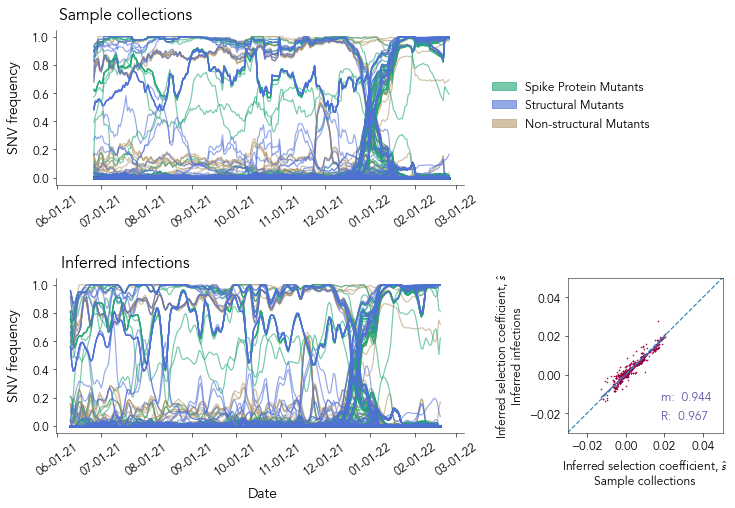

In [63]:
def plot_rescale_dates_covar_tricolor_ppt(ax, x, y, z, plot_label, start_time, end_time, scalar_map):
    
    # set font param
    mpl.rc('font', family='Avenir')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]

    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    num_lines = y.shape[1]

    for i in range(num_lines):
        site_label = new_labels[i]
        # handles reference genome insertion characters (22203a-y)
        if isinstance(site_label, str):
            site_value = int(re.sub(r'\D', '', site_label))
        else:
            site_value = int(site_label)
        
        ### comment one or other out
        # binary based on spike protein sites
        #col = 'xkcd:viridian' if (21562 <= site_value < 25384) else 'xkcd:grayish purple'
        if (21562 <= site_value < 25384):
            col = 'xkcd:jade'
        elif (25384 <= site_value):
            col = 'xkcd:cornflower blue'
        # binary based on structural sites
        #col = 'xkcd:cobalt blue' if (21562 <= site_value) else 'xkcd:orchid'
        else: col = 'xkcd:dust'
        #col = 'xkcd:viridian' if (21562 <= site_value) else 'xkcd:grayish purple'
        
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            ax.plot(x_dates, y_line, linewidth=1.2, color=col, alpha=0.6)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', labelsize=12, rotation=35, width=0.6)
    ax.tick_params(axis='y', labelsize=12, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Avenir')

    #fig.autofmt_xdate()
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    
    plt.setp(ax.get_xticklabels(), ha='center')
    
    start_date = ref_date + datetime.timedelta(int(start_time))
    end_date = ref_date + datetime.timedelta(int(end_time))
    
    ax.set_xlim(start_date, end_date)
    
    ax.set_title(plot_label, x=0.17, y=1.03, fontsize=16)

def supp_figure_rescale_dates_tricolor_ppt(index, home_dir):
    
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    # from inf_figure function
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    # gridspec parameters
    
    fig = plt.figure(figsize=(12, 7))
    #gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.5)
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.6)
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot
    
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')
    
    ax1.set_ylabel('SNV frequency', font='Avenir', size=14, labelpad=10)
    ax2.set_ylabel('SNV frequency', font='Avenir', size=14, labelpad=10)
    
    start = int(input("Enter the start date as integer or 0 for entire trajectory: "))
    end = int(input("Enter the end date as integer or 0 for entire trajectory: "))
    
    if start == 0:
        start = min(min(un_sel_x), min(bp_sel_x)) - 10 # 10 for longer traj to make fig look nice
    if end == 0:
        end = max(max(un_sel_x), max(bp_sel_x)) + 10

    plot_rescale_dates_covar_tricolor_ppt(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', start, end, None)
    plot_rescale_dates_covar_tricolor_ppt(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', start, end, None)
    
    plot_inf_supp(ax3, un_sel, bp_sel, index)
    
        
    spike_patch = mpatches.Patch(color='xkcd:jade', alpha=0.6, label='Spike Protein Mutants')
    struct_patch = mpatches.Patch(color='xkcd:cornflower blue', alpha=0.6, label='Structural Mutants')
    nonstruct_patch = mpatches.Patch(color='xkcd:dust', alpha=0.6, label='Non-structural Mutants')
    handles = [spike_patch, struct_patch, nonstruct_patch]

    #fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.22, 0.5), ncol=1, frameon=False,fontsize=6)  # Legend on the right side
    
    fig.legend(handles=handles, loc='center right', bbox_to_anchor=(0.8, 0.75), ncol=1, fontsize=12, frameon=False)  # Legend on the right side

    
    fig.supxlabel('Date', fontsize=14, y=-0.035, x=0.34)

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=1)
    
    save_path = f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/thesis_{index}_pad_tri.pdf'
    print(f"saving plot to: {save_path}")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    #plt.show()
    return fig

fig = supp_figure_rescale_dates_tricolor_ppt(27, home_dir)

In [75]:
from matplotlib.lines import Line2D
def plot_single_inf(ax, x, y, mut1, mut2, index):
    mpl.rc('font', family='Avenir')
    #plt.subplots(figsize=(12,12))
    #plt.subplots(figsize=(8,8))
    y_val = y > 0.015
    indices_where = np.where(y_val)
    y_other = (y < 0.015) #& (x < 0.015)
    indices_not = np.where(y_other)
    print(indices_where)
    #mutant = input(str("type mutation: "))
    print(mut1[0][indices_where])
    #for i in indices_where:
    for i in indices_where:
        plt.plot(x[i], y[i], 'o', label=mut2, color=rgba1, markersize=0.6)
    for i in indices_not:
        plt.plot(x[i], y[i], 'o', label=mut2, color='xkcd:cloudy blue', markersize=0.6)
    
    
    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color=rgba6, linewidth=1.2)
    

    ax = plt.gca()
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color=rgba5,linestyle='dashed',linewidth=1.2)
    ax.set_xlim(xmin=-.03, xmax=.05)
    ax.set_ylim(ymin=-.03, ymax=.05)

    #ax.set_xlabel('Coefficients, sample collections', font='Avenir', size=16, labelpad=10)
    #ax.set_ylabel('Coefficients, inferred infections', font='Avenir', size=16, labelpad=10)
    #plt.title('Selection coefficients comparison', font='Avenir', size=20, pad=20)
    #plt.subplots_adjust(bottom=0.15)

    #ax.set_aspect('equal', adjustable='box')
    
    #ax.tick_params(axis='x', labelsize=12)
    #ax.tick_params(axis='y', labelsize=12)
    #for label in ax.get_xticklabels() + ax.get_yticklabels():
    #    label.set_fontname('Avenir')
    
    x_title = 'Inferred selection coefficient, ' + r'$\hat{s}$' + '\nSample collections'
    y_title = 'Inferred selection coefficient, ' + r'$\hat{s}$' + '\nInferred infections'
    #x_title = r"$\pi$"
    ax.set_xlabel(xlabel=x_title, font='Avenir', size=12, labelpad=5, math_fontfamily='stixsans')
    ax.set_ylabel(ylabel=y_title, font='Avenir', size=12, labelpad=5, math_fontfamily='stixsans')

    #ax.set_xlabel('Coefficients, sample collections', font='Avenir', size=16, labelpad=10)
    #ax.set_ylabel('Coefficients, inferred infections', font='Avenir', size=16, labelpad=10)
    #plt.title('Selection Coefficients: Transmissions vs. Infections', font='Avenir', size=20, pad=20)
    plt.subplots_adjust(bottom=0.15)

    ax.set_aspect('equal', adjustable='box')
    
    ax.tick_params(axis='x', labelsize=12, width=0.6)
    ax.tick_params(axis='y', labelsize=12, width=0.6)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Avenir')
        
    for line in ['top', 'right']:
        ax.spines[line].set_linewidth(0.5)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
        
    lr = linregress(x, y)
        
    custom_shapes = [Line2D([0], [0], marker='o', color='w', alpha=0),
                     Line2D([0], [0], marker='o', color='w', alpha=0)]    
    custom_labels = ['m:  ' + str(round(lr.slope, 3)), 'R:  ' + str(round(lr.rvalue, 3))]
    
    ax.legend(custom_shapes, custom_labels, loc='lower right', fontsize=12, labelcolor=rgba6, frameon=False)

    
    #save_path = f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/inf_ppt_{index}.pdf'
    #print(f"saving plot to: {save_path}")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    #plt.show()
    #save_path = f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/infer_ppt_wyoming.pdf'
    #print(f"saving plot to: {save_path}")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    print(linregress(x, y))

Enter the start date as integer or 0 for entire trajectory: 0
Enter the end date as integer or 0 for entire trajectory: 0
(array([290, 484, 488, 604, 638]),)
['21766--' '22812-T' '22881-G' '24999-T' '26529-G']
LinregressResult(slope=5.242413445421102, intercept=0.0005368459464822001, rvalue=0.7177039191323045, pvalue=1.7137291902479058e-131, stderr=0.17730158218307998, intercept_stderr=0.0001472846349890924)
saving plot to: /Users/liz/Documents/GitHub/paper-epi-backprojection/figures/thesis_single_4.pdf


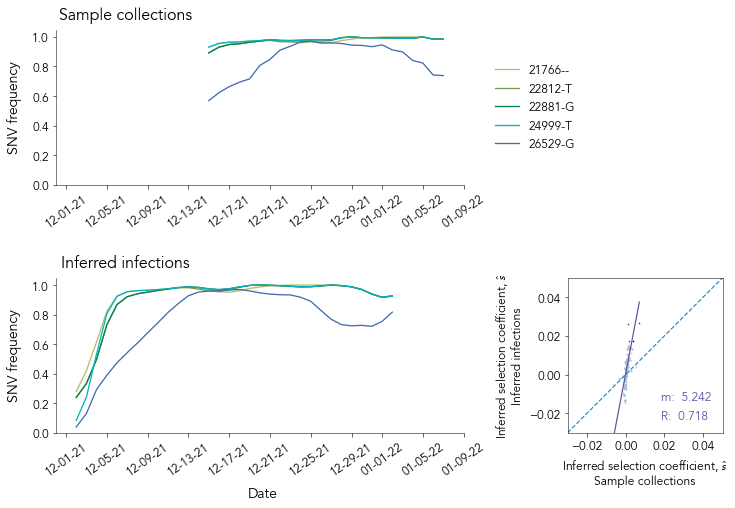

In [77]:
def plot_single_covar(ax, x, y, z, plot_label, start_time, end_time, scalar_map):
    
    # set font param
    mpl.rc('font', family='Avenir')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]

    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    num_lines = y.shape[1]

    #for i in range(num_lines):
    #    if i not in indices:
    #        y_line = y[:, i]
    ##        color = scalar_map.to_rgba(i)
    #        ax.plot(x_dates, y_line, linewidth=1.2, color=color)
    
    #for i in range(num_lines):
    #print(num_lines)
    #print(new_labels)
    # plot2: i_selected = [64,  84,  94,  99, 124, 128, 178, 264, 819]
    #plot107
    #i_selected = [85,   86,   88,   89,  790,  791,  793,  794,  844, 1031]
    #i_selected = [89,  794, 1031]
    #4
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)

    i_selected = [290, 484, 488, 604, 638]
    i_color = ['xkcd:light olive', 'xkcd:moss', 'xkcd:jungle green', 'xkcd:turquoise blue', 'xkcd:french blue']
    #i_color = ['xkcd:light olive', 'xkcd:turtle green', 'xkcd:seaweed green', 
    #           'xkcd:sea blue', 'xkcd:topaz']
    
    #i_selected = [89, 794,  844, 1031]
    #i_selected = [89,  794, 1031]
        #i_selected = [290, 484, 488, 604, 638]
    #i_color = ['xkcd:light olive', 'xkcd:sage green', 'xkcd:jungle green', 'xkcd:sea blue', 'xkcd:french blue']
    #i_color = ['xkcd:pale red', 'xkcd:gold', 'xkcd:soft green', 'xkcd:dark sea green']

    for i in range(num_lines):
        x_line = x
        y_line = y[:, i]

        if i in i_selected:
            custom_color = i_color[i_selected.index(i)]
            ax.plot(x_dates, y_line, label=new_labels[i], linewidth=1.3, color=custom_color)
    plt.subplots_adjust(bottom=0.15)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', labelsize=12, rotation=35, width=0.6)
    ax.tick_params(axis='y', labelsize=12, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Avenir')

    #fig.autofmt_xdate()
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    
    plt.setp(ax.get_xticklabels(), ha='center')
    
    start_date = ref_date + datetime.timedelta(int(start_time))
    end_date = ref_date + datetime.timedelta(int(end_time))
    
    ax.set_xlim(start_date, end_date)
    
    ax.set_title(plot_label, x=0.17, y=1.03, fontsize=16)
    
    ax.set_ylim(0,1.05)
    
    if plot_label == 'Sample collections':
        ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), frameon=False, fontsize=12)

def supp_figure_single(index, home_dir):
    
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    # from inf_figure function
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    un_mut = x['mutant_sites']
    bp_mut = y['mutant_sites']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    # gridspec parameters
    
    fig = plt.figure(figsize=(12, 7))
    #gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.5)
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.6)
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot
    
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')
    
    ax1.set_ylabel('SNV frequency', font='Avenir', size=14, labelpad=10)
    ax2.set_ylabel('SNV frequency', font='Avenir', size=14, labelpad=10)

    num_lines = un_sel_y.shape[1]
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    start = int(input("Enter the start date as integer or 0 for entire trajectory: "))
    end = int(input("Enter the end date as integer or 0 for entire trajectory: "))
    
    if start == 0:
        start = min(min(un_sel_x), min(bp_sel_x)) - 2 # 10 for longer traj to make fig look nice
    if end == 0:
        end = max(max(un_sel_x), max(bp_sel_x)) + 2

    plot_single_covar(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', start, end, scalar_map)
    plot_single_covar(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', start, end, scalar_map)
    
    plot_single_inf(ax3, un_sel, bp_sel, un_mut, bp_mut, index)
    
    
    fig.supxlabel('Date', fontsize=14, y=-0.035, x=0.34)

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=1)
    
    save_path = f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/thesis_single_{index}.pdf'
    print(f"saving plot to: {save_path}")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    #plt.show()
    return fig

fig = supp_figure_single(4, home_dir)

In [ ]:
from numpy import load
kenya_data = '/Users/liz/Documents/PhD_main/figures_visualization_writing/inference_kenya'

data_traj_n = load('traj-normal.npz')
data_traj_d = load('traj-deconv.npz')


In [ ]:
def load_npz_covar(path):
    
    #path = targeted country
    
    npz_files = [f for f in os.listdir(path) if f != ".DS_Store"]
    
    time_l = []
    count_l = []

    for file in sorted(npz_files):
        filepath = os.path.join(path, file)
        data = np.load(filepath, allow_pickle=True)
        times = data['times']
        counts = data['counts']
        refs = data['ref_sites']
        time_l.append(times)
        count_l.append(counts)

    x = np.concatenate(time_l)
    y = np.concatenate(count_l)
    z = refs
    #print(z)
    #print(np.min(x))
    #print(np.max(x))
    #print(np.min(x) , '-' , np.max(x))
    #print(str(abs(np.min(x)-np.max(x))))
    
    return x, y, z

def plot_rescale_dates_covar(ax, x, y, z, plot_label, start_time, end_time, scalar_map):
    
    # set font param
    mpl.rc('font', family='Avenir')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]

    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    num_lines = y.shape[1]

    for i in range(num_lines):
        if i not in indices:
            y_line = y[:, i]
            color = scalar_map.to_rgba(i)
            ax.plot(x_dates, y_line, linewidth=1.2, color=color)
    plt.subplots_adjust(bottom=0.15)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', labelsize=12, rotation=35, width=0.6)
    ax.tick_params(axis='y', labelsize=12, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Avenir')

    #fig.autofmt_xdate()
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    
    plt.setp(ax.get_xticklabels(), ha='center')
    
    start_date = ref_date + datetime.timedelta(int(start_time))
    end_date = ref_date + datetime.timedelta(int(end_time))
    
    ax.set_xlim(start_date, end_date)
    
    ax.set_title(plot_label, x=0.17, y=1.03, fontsize=16)

def supp_figure_rescale_dates(index, home_dir):
    
    # crawl through directory to plot each region's trajectories
    #un_covar_home = os.path.join(home_dir, 'genome-covar')
    #bp_covar_home = os.path.join(home_dir, 'bp-covar')
    un_covar_home = os.listdir(kenya_data)
    bp_covar_home = os.listdir(kenya_data)
    # from inf_figure function
    #sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    #sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    #un_cov_dir = []
    #bp_cov_dir = []

    #for d in os.listdir(un_covar_home):
    #    if ".DS_Store" in d:
    #        continue
    #    sub_dir = os.path.join(un_covar_home, d)
    #    for sd in os.listdir(sub_dir):
    #        if ".DS_Store" in sd:
    #            continue
    #        plot_dir = os.path.join(sub_dir, sd)
    #        un_cov_dir.append(plot_dir)

    #for d in os.listdir(bp_covar_home):
    #    if ".DS_Store" in d:
    #        continue
    #    sub_dir = os.path.join(bp_covar_home, d)
    #    for sd in os.listdir(sub_dir):
    #        if ".DS_Store" in sd:
    #            continue
    #        plot_dir = os.path.join(sub_dir, sd)
    #        bp_cov_dir.append(plot_dir)

    #un_cov_dir = sorted(un_cov_dir)
    #bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    #inf_file = sorted_inf_files[index]
    #x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    #inf_bp_file = sorted_bp_files[index]
    #y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    #un_sel = x['selection']
    #bp_sel = y['selection']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    # gridspec parameters
    
    fig = plt.figure(figsize=(12, 7))
    #gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.5)
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.6)
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot
    
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')
    
    ax1.set_ylabel('SNV frequency', font='Avenir', size=14, labelpad=10)
    ax2.set_ylabel('SNV frequency', font='Avenir', size=14, labelpad=10)

    num_lines = un_sel_y.shape[1]
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    start = int(input("Enter the start date as integer or 0 for entire trajectory: "))
    end = int(input("Enter the end date as integer or 0 for entire trajectory: "))
    
    if start == 0:
        start = min(min(un_sel_x), min(bp_sel_x)) - 10 # 10 for longer traj to make fig look nice
    if end == 0:
        end = max(max(un_sel_x), max(bp_sel_x)) + 10

    plot_rescale_dates_covar(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', start, end, scalar_map)
    plot_rescale_dates_covar(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', start, end, scalar_map)
    
    plot_inf_supp(ax3, un_sel, bp_sel, index)
    
    # shared colorbar (next to ax1)
    ref_sites = extract_numeric(un_ref_z)
    percentiles = np.percentile(ref_sites, [0, 25, 50, 75, 100])
    norm_cbar = Normalize(vmin=min(ref_sites), vmax=max(ref_sites))
    scalar_map = cm.ScalarMappable(norm=norm_cbar, cmap=cmap)
    #cax = fig.add_axes([0.59, 0.578, 0.02, 0.25])
    cax = fig.add_axes([0.61, 0.59, 0.02, 0.25])
    #cax = fig.add_axes([0.94, 0.4, 0.02, 0.25])
    cbar = fig.colorbar(scalar_map, cax=cax)
    
    cbar.set_label('Mutation sites', font='Avenir', size=12, labelpad=-75)
    cbar.set_ticks(percentiles)
    cbar.set_ticklabels([f'{int(p)}' for p in percentiles])
    cbar.outline.set_linewidth(0.6)

    for label in cbar.ax.get_yticklabels():
        label.set_fontname('Avenir')
        label.set_fontsize(12)
    
    fig.supxlabel('Date', fontsize=14, y=-0.035, x=0.34)

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=1)
    
    save_path = f'/Users/liz/Documents/GitHub/paper-epi-backprojection/figures/thesis_{index}_pad.pdf'
    print(f"saving plot to: {save_path}")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    #plt.show()
    return fig

fig = supp_figure_rescale_dates(15, home_dir)